# 매칭 및 확인

In [1]:
# 노트북 상위 폴더 경로 추가
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 유틸리티 함수 임포트
from src.utils import get_device, init_logger

In [3]:
logger = init_logger(name="healtheat_vision")  # 여기서만 프로젝트 이름을 지정
device = get_device()

logger.info(f"Using device: {device}")

Apple MPS GPU detected.
2025-12-16 04:21:09 - INFO - Using device: mps


In [4]:
import matplotlib as mpl
mpl.rcParams["font.family"] = "AppleGothic"   # macOS
mpl.rcParams["axes.unicode_minus"] = False

In [5]:
from pathlib import Path
import json
import pprint

root = Path("../data")
img_dir = root / "train_images"
ann_dir = root / "train_annotations"

if not img_dir.exists() or not ann_dir.exists():
    logger.error("경로가 존재하지 않습니다. 데이터 폴더를 확인하세요.")
else:
    logger.info("데이터 경로 확인 완료.")

# 2) 루트 경로의 폴더/파일 목록 로깅
folders = [p.name for p in root.iterdir() if p.is_dir()]
files   = [p.name for p in root.iterdir() if p.is_file()]

logger.info(
    f"Paths OK\n"
    f"  - img_dir : {img_dir.resolve()}\n"
    f"  - ann_dir : {ann_dir.resolve()}\n"
)

logger.info(
    "Root structure:\n"
    f"  - Folders: {folders}\n"
    f"  - Files  : {files}"
)

2025-12-16 04:21:09 - INFO - 데이터 경로 확인 완료.
2025-12-16 04:21:09 - INFO - Paths OK
  - img_dir : /Users/youuchul/Documents/github/03_projects/01_HealthEat Pill Detection Model/healtheat_vision/data/train_images
  - ann_dir : /Users/youuchul/Documents/github/03_projects/01_HealthEat Pill Detection Model/healtheat_vision/data/train_annotations

2025-12-16 04:21:09 - INFO - Root structure:
  - Folders: ['test_images', 'train_annotations', 'yolo_allmatched', 'train_annotations_raws', 'train_annotations_exp2', 'aihub_downloads', 'eda_files', 'splits_allmatched', 'train_images_raws', 'train_images', 'yolo', 'yolo_13', 'splits_13', 'train_annotations_with2', 'splits']
  - Files  : ['.DS_Store', '.gitkeep', 'README.md', 'missing_annotations.txt', 'train_annotations.zip']


In [6]:
# 1) 이미지 경로 수집
img_paths = list(img_dir.glob("*.png"))
print(f"총 이미지 수(실제 PNG): {len(img_paths)}")

# 2) 어노테이션 경로 수집 (재귀)
ann_paths = list(ann_dir.rglob("*.json"))
print(f"총 어노테이션 파일 수(JSON): {len(ann_paths)}")

# 박스 수
total_boxes = 0
for path in ann_paths:
    data = json.loads(path.read_text())
    total_boxes += len(data["annotations"])
print("JSON의 annotations 엔트리 합계", total_boxes)

# JSON 안에서 참조하는 이미지
total_image_entries = 0
json_image_names = set()

for path in ann_paths:
    data = json.loads(path.read_text())
    imgs = data["images"]
    total_image_entries += len(imgs)
    for img_info in imgs:
        json_image_names.add(img_info["file_name"])

print("JSON의 이미지 엔트리 합계:", total_image_entries)
print("JSON에서 참조하는 고유 이미지 수:", len(json_image_names))

총 이미지 수(실제 PNG): 4334
총 어노테이션 파일 수(JSON): 46926
JSON의 annotations 엔트리 합계 46926
JSON의 이미지 엔트리 합계: 46926
JSON에서 참조하는 고유 이미지 수: 12372


In [7]:
# 3) stem 기반 매핑(dict 생성)
img_dict = {p.stem: p for p in img_paths}
ann_dict = {p.stem: p for p in ann_paths}

# 4) 공통 key = 정상 매칭된 pair
common_keys = sorted(img_dict.keys() & ann_dict.keys())
print(f"매칭된 이미지-어노테이션 pair 수: {len(common_keys)}")

example_key = common_keys[0]
print("예시 key:", example_key)
print("이미지 경로:", img_dict[example_key])
print("어노테이션 경로:", ann_dict[example_key])

매칭된 이미지-어노테이션 pair 수: 3915
예시 key: K-001900-016548-019607-029451_0_2_0_2_70_000_200
이미지 경로: ../data/train_images/K-001900-016548-019607-029451_0_2_0_2_70_000_200.png
어노테이션 경로: ../data/train_annotations/K-001900-016548-019607-029451_json/K-019607/K-001900-016548-019607-029451_0_2_0_2_70_000_200.json


In [8]:
# JSON 구조 확인 (1개만)
sample_json = json.loads(ann_dict[example_key].read_text())
print(f"Annotation File: {ann_dict[example_key].name}")
print("\nJSON Key 구조:", sample_json.keys())
pprint.pp(sample_json)

Annotation File: K-001900-016548-019607-029451_0_2_0_2_70_000_200.json

JSON Key 구조: dict_keys(['images', 'type', 'annotations', 'categories'])
{'images': [{'file_name': 'K-001900-016548-019607-029451_0_2_0_2_70_000_200.png',
             'width': 976,
             'height': 1280,
             'imgfile': 'K-001900-016548-019607-029451_0_2_0_2_70_000_200.png',
             'drug_N': 'K-019607',
             'drug_S': '정상알약',
             'back_color': '연회색 배경',
             'drug_dir': '앞면',
             'light_color': '주백색',
             'camera_la': 70,
             'camera_lo': 0,
             'size': 200,
             'dl_idx': '19606',
             'dl_mapping_code': 'K-019607',
             'dl_name': '스토가정 10mg',
             'dl_name_en': 'Stogar Tab. 10mg',
             'img_key': 'http://connectdi.com/design/img/drug/1MrFeLzYHjR.jpg',
             'dl_material': '라푸티딘',
             'dl_material_en': 'Lafutidine',
             'dl_custom_shape': '정제, 저작정',
             'dl_com

In [9]:
from pathlib import Path
root = Path("../data")
img_dir = root / "train_images"

print("train_images exists:", img_dir.exists())
print("png count:", len(list(img_dir.rglob("*.png"))))
print("PNG count:", len(list(img_dir.rglob("*.PNG"))))
print("jpg count:", len(list(img_dir.rglob("*.jpg"))))
print("jpeg count:", len(list(img_dir.rglob("*.jpeg"))))

# 예시 20개
samples = list(img_dir.rglob("*.*"))[:20]
for p in samples:
    print(p)

train_images exists: True
png count: 4334
PNG count: 0
jpg count: 0
jpeg count: 0
../data/train_images/K-006835-026993-030850-038972_0_2_0_2_70_000_200.png
../data/train_images/K-010487-020004-035659-053384_0_2_0_2_90_000_200.png
../data/train_images/K-003614-020877-025367-035206_0_2_0_2_90_000_200.png
../data/train_images/K-010224-016551-023203-027926_0_2_0_2_70_000_200.png
../data/train_images/K-003832-016206-029667_0_2_0_2_75_000_200.png
../data/train_images/K-005391-032310-035206_0_2_0_2_75_000_200.png
../data/train_images/K-004543-010224-016551-029871_0_2_0_2_75_000_200.png
../data/train_images/K-003614-020877-029667-030308_0_2_0_2_90_000_200.png
../data/train_images/K-003544-006563-012247-016548_0_2_0_2_90_000_200.png
../data/train_images/K-004543-010221-016548-024850_0_2_0_2_75_000_200.png
../data/train_images/K-006835-019881-023319-038927_0_2_0_2_75_000_200.png
../data/train_images/K-003743-005886-019552-038954_0_2_0_2_70_000_200.png
../data/train_images/K-003614-027733-030308-

In [10]:
# 0) 이미지 인덱스 만들기 (stem -> path)
img_index = {}
for p in (root / "train_images").rglob("*"):
    if p.is_file() and p.suffix.lower() in [".png", ".jpg", ".jpeg", ".webp"]:
        img_index[p.stem] = p

print("인덱싱된 이미지 수:", len(img_index))

def find_image_by_filename(filename: str) -> Path | None:
    return img_index.get(Path(filename).stem)

인덱싱된 이미지 수: 4334


인덱싱된 이미지 수: 4334
전체 annotation json 수: 46926
이미지 매칭되는 annotation json 수: 14739
샘플 JSON: ../data/train_annotations/K-010224-012247-016551-029451_json/K-016551/K-010224-012247-016551-029451_0_2_0_2_90_000_200.json


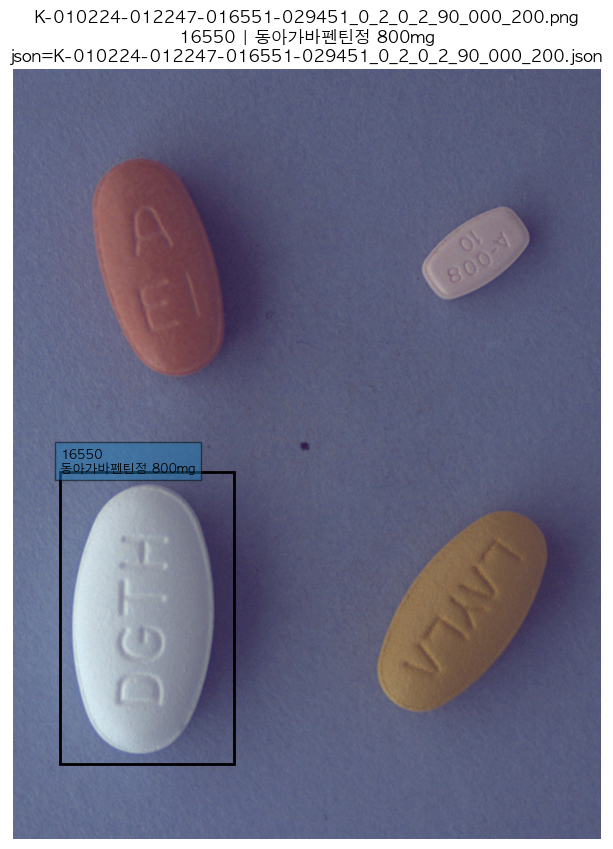

In [11]:
from pathlib import Path
import json
import random

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

root = Path("../data")

img_dir = root / "train_images"
ann_root = root / "train_annotations"

# =========================
# 1) 이미지 stem -> path 인덱스 만들기
# =========================
img_index = {p.stem: p for p in img_dir.glob("*.png")}
print("인덱싱된 이미지 수:", len(img_index))

# =========================
# 2) 이미지가 실제로 존재하는 JSON만 필터링
#    (JSON의 file_name stem이 img_index에 있어야 함)
# =========================
json_paths = list(ann_root.rglob("*.json"))
print("전체 annotation json 수:", len(json_paths))

matched_json_paths = []
for jp in json_paths:
    data = json.loads(jp.read_text(encoding="utf-8", errors="replace"))
    filename = data["images"][0]["file_name"]
    if Path(filename).stem in img_index:
        matched_json_paths.append(jp)

print("이미지 매칭되는 annotation json 수:", len(matched_json_paths))


def visualize_one_annotation(json_path: Path, show_max_boxes: int = 50):
    data = json.loads(json_path.read_text(encoding="utf-8", errors="replace"))

    img_info = data["images"][0]
    filename = img_info["file_name"]
    stem = Path(filename).stem

    img_path = img_index.get(stem)
    if img_path is None:
        print("❌ 이미지 못 찾음:", filename)
        print("JSON:", json_path)
        return

    # 라벨 정보(약품명)
    cat = (data.get("categories") or [{}])[0]
    drug_name = cat.get("name", "")
    drug_id = cat.get("id", None)

    img = Image.open(img_path).convert("RGB")

    fig, ax = plt.subplots(figsize=(8, 10))
    ax.imshow(img)
    ax.set_title(f"{filename}\n{drug_id} | {drug_name}\njson={json_path.name}")
    ax.axis("off")

    anns = data.get("annotations", [])[:show_max_boxes]
    for ann in anns:
        x, y, bw, bh = ann["bbox"]
        rect = patches.Rectangle((x, y), bw, bh, fill=False, linewidth=2)
        ax.add_patch(rect)

        cid = ann.get("category_id")
        ax.text(
            x, y,
            f"{cid}\n{drug_name}",
            fontsize=9,
            bbox=dict(alpha=0.5)
        )

    plt.show()


# =========================
# 3) 실행: 이미지가 있는 JSON 중 랜덤 1개 시각화
# =========================
sample_json = random.choice(matched_json_paths)
print("샘플 JSON:", sample_json)
visualize_one_annotation(sample_json)